# ElectroStatic Potential Field

## Units

- Distance: $Å$
- Charge: $e$
- Dipole: $eÅ$ or $D=0.2081943 \; eÅ$
- Potential: $V$
- Potential / Coulomb constant: $e/Å$

## Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
sys.path.append('../src/')
import constants
import read
import espf
from fireball import FireballResults
from vdwsurface import vdw_surface

## Read and check input

In [2]:
result = FireballResults("H2O")

In [3]:
# Positions in Å
print("Atoms:")
print(result.symbols)
print("Positions:")
print(result.rqs)

Atoms:
['O' 'H' 'H']
Positions:
[[ 0.        0.        0.40788 ]
 [ 0.        0.765385 -0.20394 ]
 [ 0.       -0.765385 -0.20394 ]]


In [4]:
# Charges in e
print("iqout = 4: ", result.qs[4])
print("iqout = 7: ", result.qs[7])

iqout = 4:  [-0.31085882  0.15542904  0.15542904]
iqout = 7:  [-0.6203359   0.31016758  0.31016757]


In [5]:
# Dipoles in Debye
print("iqout = 4: ", espf.compute_dipole(result.rqs, result.qs[4]))
print("iqout = 7: ", espf.compute_dipole(result.rqs, result.qs[7]))

iqout = 4:  [ 0.00000000e+00 -1.38797301e-17 -9.13519209e-01]
iqout = 7:  [ 0.00000000e+00  3.67630144e-08 -1.82297862e+00]


In [6]:
# Reconstruct dipole with 2 charges
print("Original dipole:")
print(result.totaldips[0])
rqdip, qdip = espf.dipole2charges(result.rqs[0], result.totaldips[0], d=1)
print("Positions:")
print(rqdip)
print("Charges:")
print(qdip)
print("Reconstructed dipole from charges:")
print(espf.compute_dipole(rqdip, qdip))

Original dipole:
[-0.      0.     -0.7944]
Positions:
[[ 0.       0.       0.90788]
 [ 0.       0.      -0.09212]]
Charges:
[-0.16538955  0.16538955]
Reconstructed dipole from charges:
[ 0.      0.     -0.7944]


In [7]:
# Check how big is the VdW surface (scaled by 2)
# The VdW surface should be contained inside the "minicell"
# For each direction (x, y or z) i, the VdW ranges from min[i] to max[i]
# The minicell ranges from -minilvs/2 to minilvs/2
vdw = []
for s, p in zip(result.symbols, result.rqs):
    vdw.append(p - 2*constants.BONDI_RADII[s])
    vdw.append(p + 2*constants.BONDI_RADII[s])
vdw = np.array(vdw)
min = np.min(vdw, axis=0)
max = np.max(vdw, axis=0)

print("VdW surface:")
print(min)
print(max)
print("minicell:")
print(result.minilvs/2)

VdW surface:
[-3.04     -3.165385 -2.63212 ]
[3.04     3.165385 3.44788 ]
minicell:
[[3.911285 0.       0.      ]
 [0.       3.911285 0.      ]
 [0.       0.       3.911285]]


## Along 1D axis

(-0.7, 0.5)

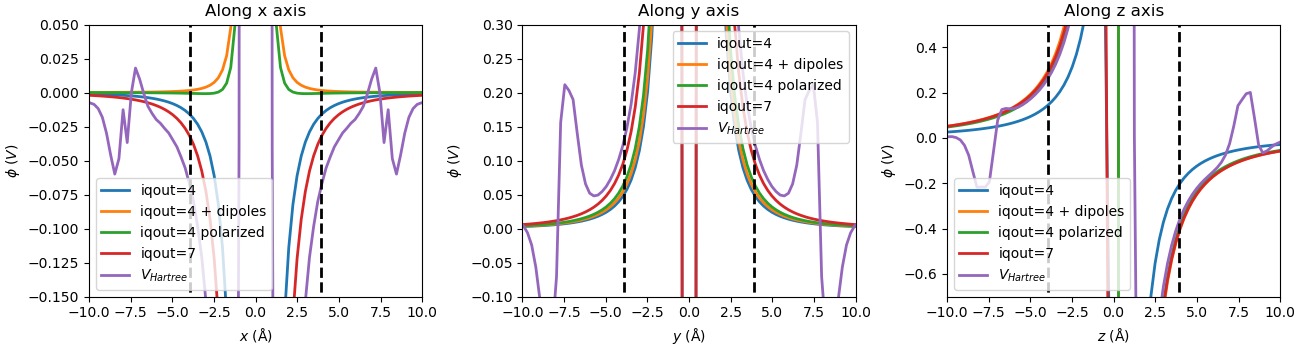

In [8]:
# ElectroStatic Potential along 1D direction

fig, axs = plt.subplots(1, 3, figsize=(13, 3.5), layout='constrained')

directions = [np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]), np.array([0.0, 0.0, 1.0])]
def midslice(object, dim):
    index = (np.array(object.shape) - 1)/2                                                                     
    index = index.astype(int)
    index = list(index)
    index[dim] = slice(None, None, None)
    index = tuple(index)
    return object[index]

for dim in range(3):
    rs = np.array([r*directions[dim] for r in result.grid3d[dim]])
    # iqout = 4
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(result.rqs, result.qs[4], rs), lw=2, label="iqout=4")
    # iqout = 4 + dipoles
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(result.rqs, result.qs[4], rs) + espf.dipoles_espf(result.rqs, result.totaldips, rs), lw=2, label="iqout=4 + dipoles")
    # iqout = 4 polarized
    rqdips, qdips = espf.dipole2charges(result.rqs[0], result.totaldips[0], d=0.01)
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(result.rqs, result.qs[4], rs) + espf.pointcharges_espf(rqdips, qdips, rs), lw=2, label="iqout=4 polarized")
    # iqout = 7
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(result.rqs, result.qs[7], rs), lw=2, label="iqout=7")
    # V_Hartree
    axs[dim].plot(rs[:, dim], midslice(result.vhartree3d, dim), lw=2, label="$V_{Hartree}$")

    # minicell
    axs[dim].plot([result.minilvs[dim, dim]/2, result.minilvs[dim, dim]/2], [-10, 10], 'k--', lw=2)
    axs[dim].plot([-result.minilvs[dim, dim]/2, -result.minilvs[dim, dim]/2], [-10, 10], 'k--', lw=2)
    
    axs[dim].set_ylabel("$\phi$ ($V$)")
    axs[dim].legend()

axs[0].set_title("Along x axis")
axs[0].set_xlabel("$x$ (Å)")
axs[1].set_title("Along y axis")
axs[1].set_xlabel("$y$ (Å)")
axs[2].set_title("Along z axis")
axs[2].set_xlabel("$z$ (Å)")

axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-0.15, 0.05)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-0.1, 0.3)
axs[2].set_xlim(-10, 10)
axs[2].set_ylim(-0.7, 0.5)

## On 2D plane

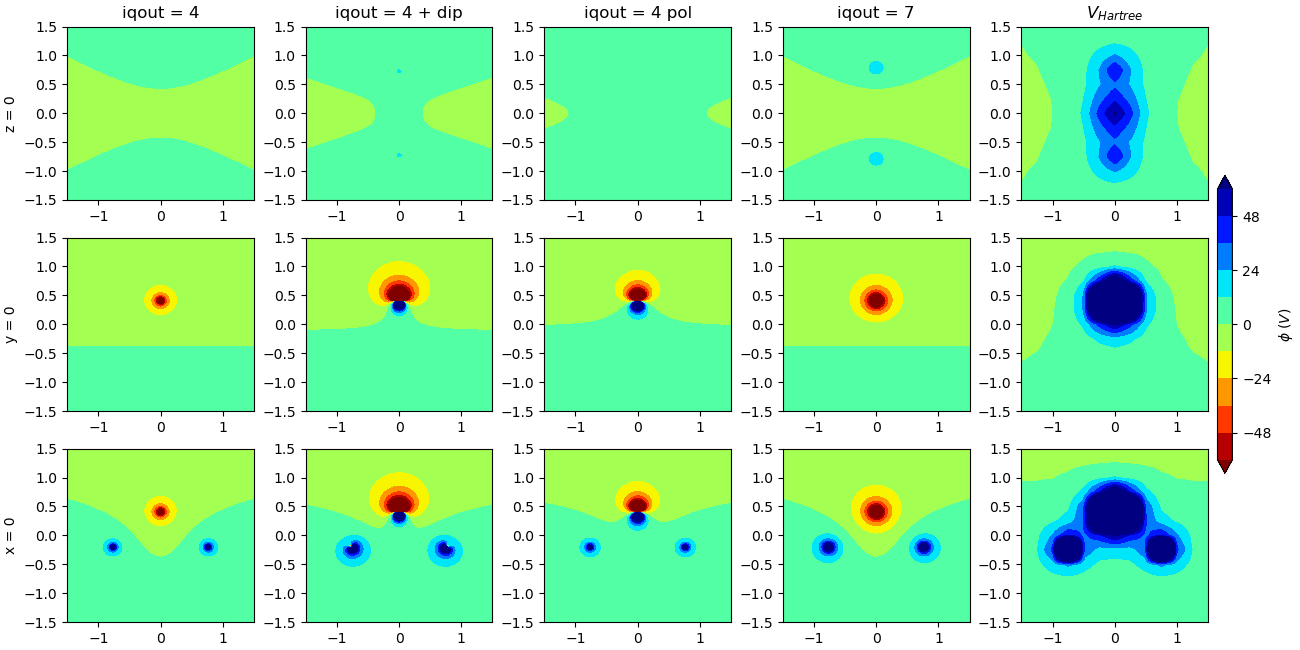

In [9]:
# ElectroStatic Potential on 2D plane

def espfq7(result, rs): return espf.pointcharges_espf(result.rqs, result.qs[7], rs)
def espfq4(result, rs): return espf.pointcharges_espf(result.rqs, result.qs[4], rs)
def espfq4dip(result, rs): return espf.pointcharges_espf(result.rqs, result.qs[7], rs) + espf.dipoles_espf(result.rqs, result.totaldips, rs)
d_test = 0.1
def espfq4pol(result, rs):
    rqdips, qdips = espf.dipole2charges(result.rqs[0], result.intradips[0], d=d_test)
    return espf.pointcharges_espf(result.rqs, result.qs[4], rs) + espf.pointcharges_espf(rqdips, qdips, rs)
def espfvhartree(result, rs): return espf.interpolate_espf(result.grid3d, result.vhartree3d, rs)
espfs = [espfq4, espfq4dip, espfq4pol, espfq7, espfvhartree]
titles = ["iqout = 4", "iqout = 4 + dip",  "iqout = 4 pol", "iqout = 7", "$V_{Hartree}$"]

fig, axs = plt.subplots(3, len(espfs), figsize=(13, 6.5), layout='constrained')
levels = np.linspace(-60, 60, 11)

for i in range(len(espfs)):
    xs = np.linspace(-1.5, 1.5, 101)
    ys = np.linspace(-1.5, 1.5, 101)
    rs = np.array([np.array([x, y, 0]) for y in ys for x in xs])
    axs[0, i].contourf(xs, ys, np.reshape(espfs[i](result, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')
    axs[0, i].set_title(titles[i])
    
    xs = np.linspace(-1.5, 1.5, 101)
    zs = np.linspace(-1.5, 1.5, 101)
    rs = np.array([np.array([x, 0, z]) for z in zs for x in xs])
    axs[1, i].contourf(xs, zs, np.reshape(espfs[i](result, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')
    
    ys = np.linspace(-1.5, 1.5, 101)
    zs = np.linspace(-1.5, 1.5, 101)
    rs = np.array([np.array([0, y, z]) for z in zs for y in ys])
    cf = axs[2, i].contourf(ys, zs, np.reshape(espfs[i](result, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')

axs[0, 0].set_ylabel("z = 0")
axs[1, 0].set_ylabel("y = 0")
axs[2, 0].set_ylabel("x = 0")
    
fig.colorbar(cf, ax=axs[:, -1], shrink=0.5, label="$\phi$ ($V$)")

## In 3D space

In [10]:
# Generate the VdW surfaces
points, mesh = vdw_surface(result.rqs, result.symbols, density=100, scale_factor=1.0) # 1.4, 1.6, 1.8, and 2.0.
points_4layers = np.concatenate((vdw_surface(result.rqs, result.symbols, density=100, scale_factor=1.4)[0],
                                 vdw_surface(result.rqs, result.symbols, density=100, scale_factor=1.6)[0],
                                 vdw_surface(result.rqs, result.symbols, density=100, scale_factor=1.8)[0],
                                 vdw_surface(result.rqs, result.symbols, density=100, scale_factor=2.0)[0]))
gpoints_4layers, _ = espf.nearest_gridpoints_espf(result.grid3d, result.vhartree3d, points_4layers)

In [11]:
result.check_points(points_4layers)

ESP charges:  [-0.58202502  0.29101251  0.29101251]


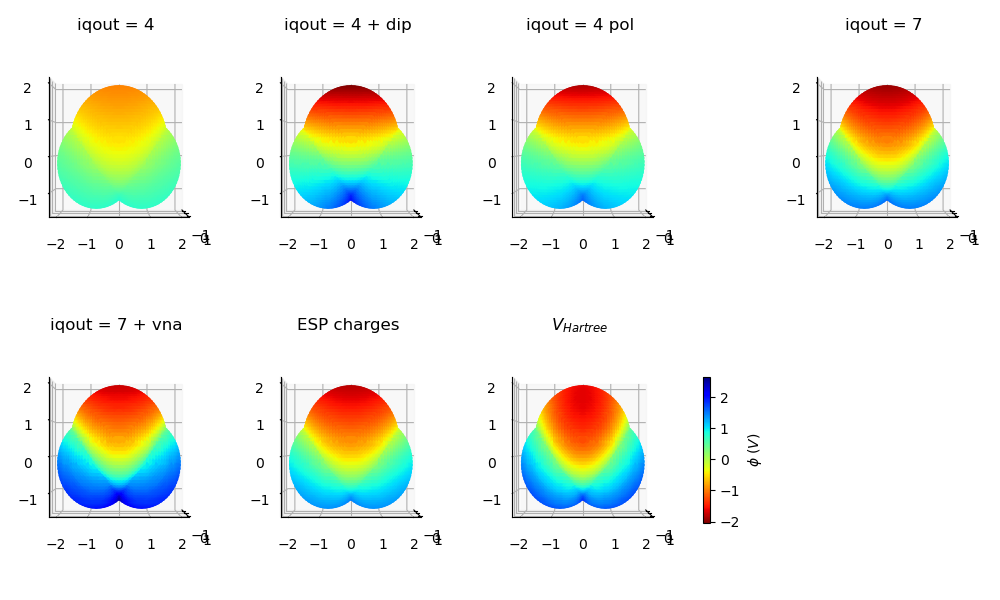

In [12]:
# ElectroStatic Potential in 3D space

fig = plt.figure(figsize=(10, 6), layout='constrained')

espf_q4 = espf.pointcharges_espf(result.rqs, result.qs[4], points)
espf_q4dip = (espf.pointcharges_espf(result.rqs, result.qs[4], points) + espf.dipoles_espf(result.rqs, result.totaldips, points))
d_test = 0.1
rqdips, qdips = espf.dipole2charges(result.rqs[0], result.intradips[0], d=d_test)
espf_q4pol = espf.pointcharges_espf(result.rqs, result.qs[4], points) + espf.pointcharges_espf(rqdips, qdips, points)
espf_q7 = espf.pointcharges_espf(result.rqs, result.qs[7], points)
espf_q7vna = espf.pointcharges_espf(result.rqs, result.qs[7], points) + espf.interpolate_espf(result.grid3d, result.vna3d, points)
espf_vhartree = espf.interpolate_espf(result.grid3d, result.vhartree3d, points)

espf_vhartree_4layers = espf.interpolate_espf(result.grid3d, result.vhartree3d, points_4layers)
result.compute_espcharges(points_4layers)
print("ESP charges: ", result.qs["esp"])
espf_qesp = espf.pointcharges_espf(result.rqs, result.qs["esp"], points)

espfs = [espf_q4, espf_q4dip, espf_q4pol, espf_q7, espf_q7vna, espf_qesp, espf_vhartree]
titles = ["iqout = 4", "iqout = 4 + dip", "iqout = 4 pol", "iqout = 7", "iqout = 7 + vna", "ESP charges", "$V_{Hartree}$"]

allvalues = np.concatenate(espfs)
min, max = allvalues.min(), allvalues.max()
norm = plt.Normalize(min, max)

for i in range(len(espfs)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=espfs[i], cmap=mpl.cm.jet_r, norm=norm)
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$\phi$ ($V$)")

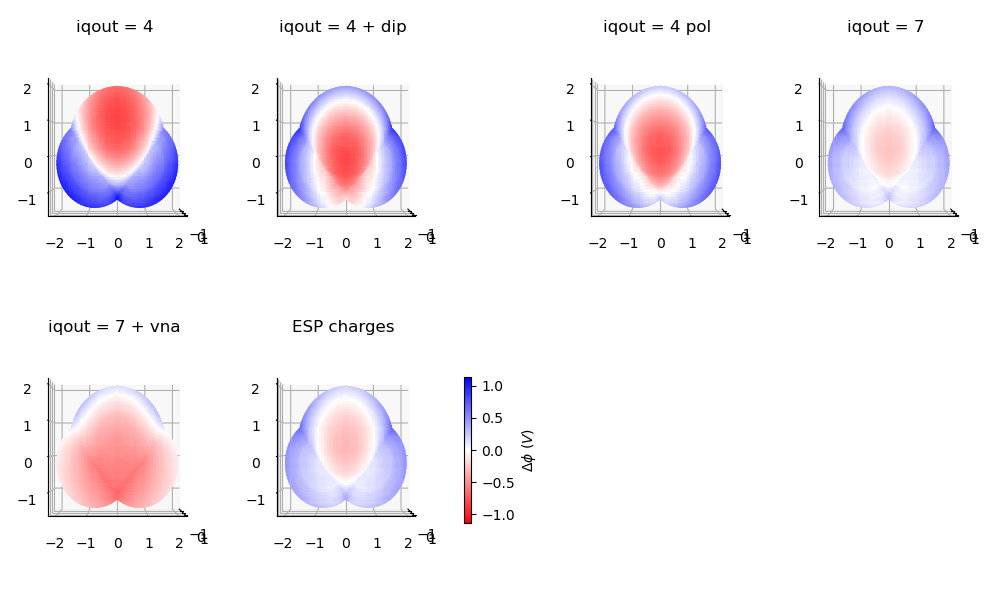

In [13]:
# Difference between the ElectroStatic Potential calculated with the charges and dipoles, and the Hartree Potential from the Fireball calculation

fig = plt.figure(figsize=(10, 6), layout='constrained')

d_espfs = [espf_vhartree-espf_ for espf_ in espfs[:-1]]

allvalues = np.concatenate(d_espfs)
min, max = -np.absolute(allvalues).max(), np.absolute(allvalues).max()
norm = plt.Normalize(min, max)

for i in range(len(d_espfs)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=d_espfs[i], cmap=mpl.cm.bwr_r, norm=norm)
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$\Delta\phi$ ($V$)")

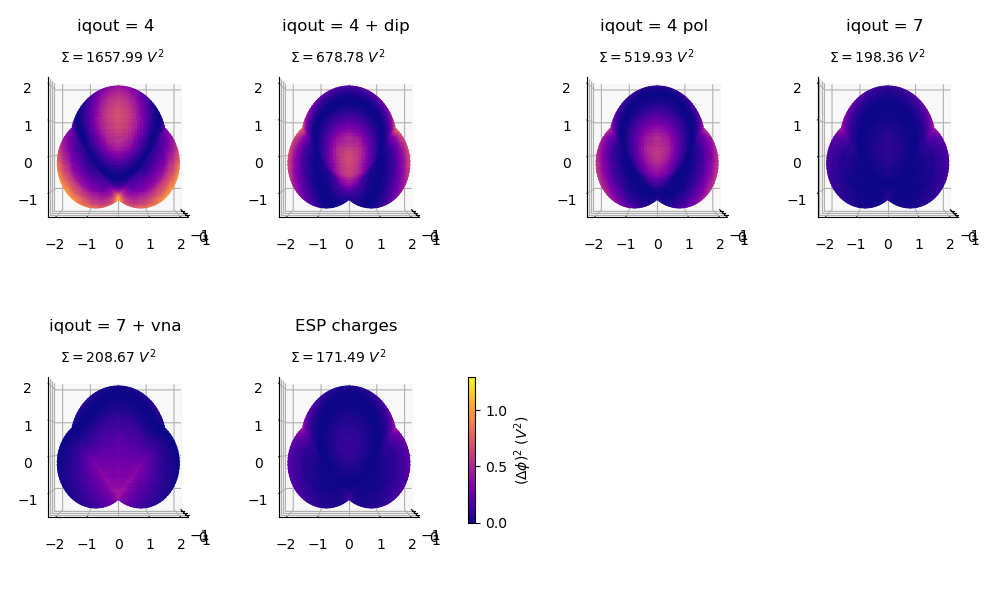

In [14]:
# Difference squared between the ElectroStatic Potential calculated with the charges and dipoles, and the Hartree Potential from the Fireball calculation
# Σ is the total difference of the Potential added for the points in the 1.4, 1.6, 1.8 and 2 - scaled VdW surfaces

fig = plt.figure(figsize=(10, 6), layout='constrained')

espf_q4_4layers = espf.pointcharges_espf(result.rqs, result.qs[4], points_4layers)
espf_q4dip_4layers = (espf.pointcharges_espf(result.rqs, result.qs[4], points_4layers) + espf.dipoles_espf(result.rqs, result.totaldips, points_4layers))
espf_q7_4layers = espf.pointcharges_espf(result.rqs, result.qs[7], points_4layers)
espf_q7vna_4layers = espf.pointcharges_espf(result.rqs, result.qs[7], points_4layers) + espf.interpolate_espf(result.grid3d, result.vna3d, points_4layers)
espf_qesp_4layers = espf.pointcharges_espf(result.rqs, result.qs["esp"], points_4layers)

espf_q4pol_4layers = espf.pointcharges_espf(result.rqs, result.qs[4], points_4layers) + espf.pointcharges_espf(rqdips, qdips, points_4layers)

espfs_4layers = [espf_q4_4layers, espf_q4dip_4layers, espf_q4pol_4layers, espf_q7_4layers, espf_q7vna_4layers, espf_qesp_4layers]
d_espfs_2 = [(espf_vhartree-espf_)**2 for espf_ in espfs[:-1]]

allvalues = np.concatenate(d_espfs_2)
min, max = 0, np.absolute(allvalues).max()
norm = plt.Normalize(min, max)

for i in range(len(d_espfs_2)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=d_espfs_2[i], cmap=mpl.cm.plasma, norm=norm)
    ax.text(0, -2, 2.7, "$\Sigma = $"+f"{(np.sum((espfs_4layers[i]-espf_vhartree_4layers)**2)):.2f}"+" $V^2$")
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$(\Delta\phi)^2$ ($V^2$)")

## Dev testing